<a href="https://colab.research.google.com/github/M-Salim-I/Other-Projects/blob/main/Curve_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modules/Libraries 

In [1]:
# Uncomment if use Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
%matplotlib inline
from datetime import datetime 
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

Mounted at /content/gdrive


# Task1: Create the training dataset and dataloader (10%) [PART 1]

In [2]:
Nf = 2000 # 2000 sine functions of the form a * sin(x + a)
Npts = 40 # 40 points for each function
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)
x += torch.rand_like(x)*0.1
# uniformly distributed, maybe a not dep on x so not torch.grad = False
a = -2 + 4 * torch.rand(Nf).view(-1, 1).repeat(1, Npts).unsqueeze(2)
y = a * torch.sin(x + a)
print(x.size(), y.size())

torch.Size([2000, 40, 1]) torch.Size([2000, 40, 1])


In [3]:
dataset = data.TensorDataset(x, y) # dataset full of tensors of x and y points

# Hyperparameters

In [4]:
BS = 64 # number of training samples in one forward & backward pass
h_dim = 100 # number of neurons for our hidden layers in both of the MLPs
r_dim = 100 # number of dimensions we choose for our feature representation
LR, WD = 1e-3, 0 # learinig rate & weight decay for the optimizers
EPOCHS = 100 # number of forward & backward pass of all training samples

# Task1: Create the training dataset and dataloader (10%) [PART 2]

In [5]:
# iterates over the data and allows to feed the data 
# in small increments into the network
# shuffle gives the neural network the opportunity to learn general principles
data_iter =  data.DataLoader(dataset, batch_size = BS, shuffle = True)
train_iter = iter(data_iter) # iterates through the data

# Task 2: Create the Encoder and Decoder (20 + 20%)

In [6]:
class ENCODER(nn.Module):
    def __init__(self, n_inputs = 2, n_hidden = h_dim, n_outputs = r_dim):
        super(ENCODER, self).__init__()
        # number of neurons for each type of layer in our network
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs

        # NN with 3 hidden layers
        self.FC1 = nn.Linear(n_inputs, n_hidden)
        self.FC2 = nn.Linear(n_hidden, n_hidden)
        self.FC3 = nn.Linear(n_hidden, n_hidden)
        self.FC4 = nn.Linear(n_hidden, n_hidden)
        self.FC5 = nn.Linear(n_hidden, n_outputs)

    def forward(self, x):
      # forward pass through our network
      H1_output = F.relu(self.FC1(x))
      H2_output = F.relu(self.FC2(H1_output))
      H3_output = F.relu(self.FC3(H2_output))
      H4_output = F.relu(self.FC4(H3_output))
      r_c = self.FC5(H4_output)
      return r_c

In [7]:
class DECODER(nn.Module):
    def __init__(self, n_inputs = r_dim + 1, n_hidden = h_dim, n_outputs = 1):
        super(DECODER, self).__init__()
        # number of neurons for each type of layer in our network
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs

        # NN with 3 hidden layers
        self.FC1 = nn.Linear(n_inputs, n_hidden)
        self.FC2 = nn.Linear(n_hidden, n_hidden)
        self.FC3 = nn.Linear(n_hidden, n_hidden)
        self.FC4 = nn.Linear(n_hidden, n_hidden)
        self.FC5 = nn.Linear(n_hidden, n_outputs)

    def forward(self, x):
      # forward pass through our network
      H1_output = F.relu(self.FC1(x))
      H2_output = F.relu(self.FC2(H1_output))
      H3_output = F.relu(self.FC3(H2_output))
      H4_output = F.relu(self.FC4(H3_output))
      decoder_output = self.FC5(H4_output)
      return decoder_output

Reference of implementation of function in code cell below:
https://qmplus.qmul.ac.uk/pluginfile.php/2182817/mod_resource/intro/Week05_Lab_with_answers.ipynb

In [8]:
# Function to iniitialize all the weights for each layer in our model but optinal
'''
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std = 1e-3)
        torch.nn.init.zeros_(m.bias)
'''
enc = ENCODER()
dec = DECODER()
'''
# Initializing the weights of both of our network
enc.apply(init_weights)
dec.apply(init_weights)
'''
print(enc, dec)

ENCODER(
  (FC1): Linear(in_features=2, out_features=100, bias=True)
  (FC2): Linear(in_features=100, out_features=100, bias=True)
  (FC3): Linear(in_features=100, out_features=100, bias=True)
  (FC4): Linear(in_features=100, out_features=100, bias=True)
  (FC5): Linear(in_features=100, out_features=100, bias=True)
) DECODER(
  (FC1): Linear(in_features=101, out_features=100, bias=True)
  (FC2): Linear(in_features=100, out_features=100, bias=True)
  (FC3): Linear(in_features=100, out_features=100, bias=True)
  (FC4): Linear(in_features=100, out_features=100, bias=True)
  (FC5): Linear(in_features=100, out_features=1, bias=True)
)


# Task 3: Create the optimizer and the loss for your model (10%)

In [9]:
# we choose the Adam optimizer for both of the NNs
enc_optimizer = optim.Adam(enc.parameters(), lr = LR, weight_decay = WD)
dec_optimizer = optim.Adam(dec.parameters(), lr = LR, weight_decay = WD)
# we choosse the mean squared error loss for the overall loss of the 2 NNs
loss = nn.MSELoss()

# Task 4: Write the training script that will train the model and print the training loss (30%)

In [10]:
track_loss = []
start = datetime.now()
print("Training started")
for epoch in range(EPOCHS):
  # loop over all batches
  for X, y in data_iter:
    # picking random number of context points and feeding it to our network
    # number of context points changes after each iteration
    N_c = random.randint(1, Npts - 1)
    randomPairs = random.sample(range(0, Npts), N_c)
    x_c, y_c = X[:, randomPairs, :], y[: , randomPairs, :]
    # concatenating 2 tensors together to get (x_c, y_c)
    x = torch.cat((x_c, y_c), dim = 2)
    # forward pass
    r_c = enc(x)
    # intermediate step
    # calculating the mean of the feature representation
    # mean of each feature for each function of each batch
    r_C = torch.mean(r_c, dim = 1, keepdim = True)
    # concatenating 2 tensors together to get (r_C, x_t)
    t = torch.cat((r_C.expand((r_C.shape[0], X.shape[1], r_C.shape[-1])), X), 
                  dim = -1)
    y_hat_t = dec(t)
    # making sure to clear gradients at each iteration
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    # calcuates the the loss between predicted y values and actual y values
    l = loss(y_hat_t, y)
    # backward pass
    l.backward()
    # update the weights for each optimizer
    enc_optimizer.step()
    dec_optimizer.step()
  # stores loss after each epoch in track_loss list
  track_loss.append(l.item())
  # remember epoch 0 is the 1st epoch
  # printing the loss after every 30th epoch
  if (epoch + 1) % 10 == 0:
    print(f'epoch: {epoch + 1}, loss = {l.item():.4f}')
  # early stopping
  if l.item() < 1e-3:
    print(f'epoch: {epoch + 1}, loss = {l.item():.4f}')
    break
duration = datetime.now() - start
print("Training completed in time: ", duration)

Training started
epoch: 10, loss = 0.0150
epoch: 20, loss = 0.0309
epoch: 30, loss = 0.0259
epoch: 40, loss = 0.0057
epoch: 50, loss = 0.1551
epoch: 60, loss = 0.0019
epoch: 70, loss = 0.0108
epoch: 80, loss = 0.0022
epoch: 87, loss = 0.0010
Training completed in time:  0:01:00.130778


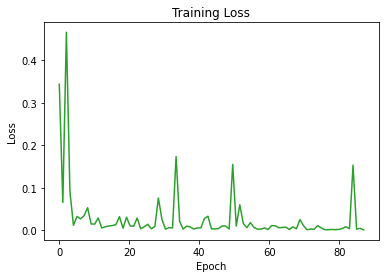

In [11]:
x = torch.linspace(0, len(track_loss), len(track_loss))
plt.plot(x, track_loss, color = 'C2', label = 'Training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss");

In [12]:
# turning tensors to numpy arrays so we are able to plot in matplotlib
y_hat_t_train = y_hat_t.detach().numpy()

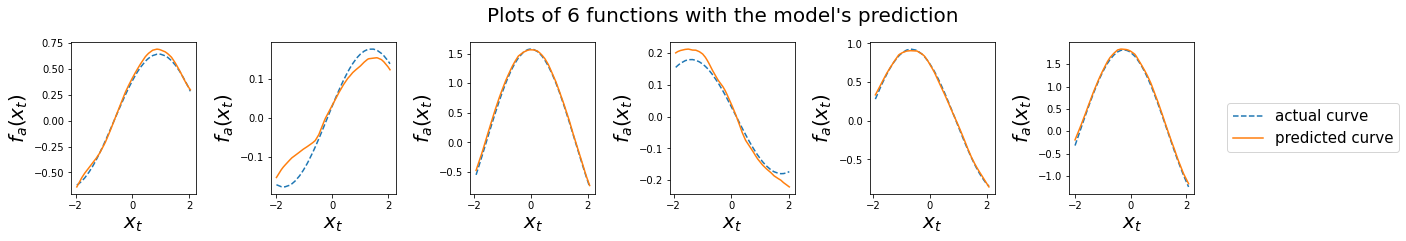

In [13]:
# plotting in a 1x6 grid
fig, ax = plt.subplots(1, 6, figsize = (20, 3))
axes = 0
# plot each function and the model prediction of the function in the same plot
for i in range(0, 6):
  ax[axes].plot(X[i, : , : ], y[i, :, :], color = "C0", linestyle = "--")
  ax[axes].plot(X[i, :, :], y_hat_t_train[i, :, :], color = "C1")
  ax[axes].set_xlabel("$x_{t}$", fontsize = 20)
  ax[axes].set_ylabel("$f_{a}(x_{t})$", fontsize = 20)
  axes +=1
plt.legend(["actual curve", "predicted curve"], loc='upper center', 
           bbox_to_anchor = (1.95, 0.65), ncol = 1, fontsize = 15)
fig.suptitle("Plots of 6 functions with the model's prediction", 
             fontsize = 20, y = 1.1)
plt.tight_layout();

# Task 5: Evaluate the model on some validation data. Plot some predictions. (10%)

In [14]:
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data = pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 6 # i=1,..6
name = 'function_num_{}'.format(i)
x_c = test_data[name]['context_pairs'][0]
y_c = test_data[name]['context_pairs'][1]
x_t = test_data[name]['x']

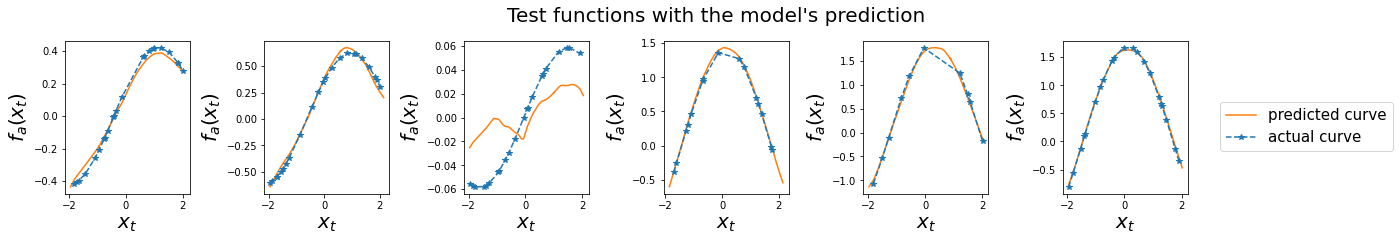

In [15]:
# plotting in a 1x6 grid for 6 plots
fig, ax = plt.subplots(1, 6, figsize = (20, 3))
axis = 0

for i in range(1, 7):
  name = 'function_num_{}'.format(i)
  # extracting the context pairs out of the dictionary for each function
  x_c = test_data[name]['context_pairs'][0]
  y_c = test_data[name]['context_pairs'][1]
  # extracting the domain of x values for each function
  x_t = test_data[name]['x']

  # Applying the optimized model
  x = torch.cat((x_c, y_c), 2)
  r_c = enc(x)
  r_C = torch.mean(r_c, 1, True)
  t = torch.cat((r_C.expand((r_C.shape[0], x_t.shape[1], r_C.shape[2])), x_t), 
                dim = -1)
  y_hat_t = dec(t)
  y_hat_t = y_hat_t.detach().numpy()

  # preparing to plot the context points in "order"
  # converting the context points to lists and keeping only 2 dimensions
  x_c = [i for i in x_c.squeeze(0).view(1, -1).tolist()[0]]
  y_c = [i for i in y_c.squeeze(0).view(1, -1).tolist()[0]]
  x_c, y_c = zip(*sorted(zip(x_c, y_c)))
  # plot each test function with the model's prediction in the same plot
  ax[axis].plot(x_t.squeeze(0), y_hat_t.squeeze(0), color = "C1")
  ax[axis].plot(x_c, y_c, color = "C0", marker = "*", linestyle = "--")
  ax[axis].set_xlabel("$x_{t}$", fontsize = 20)
  ax[axis].set_ylabel("$f_{a}(x_{t})$", fontsize = 20)
  axis += 1

plt.legend(["predicted curve", "actual curve"], loc = 'upper center', 
           bbox_to_anchor=(1.95, 0.65), ncol = 1, fontsize = 15)
fig.suptitle("Test functions with the model's prediction", 
             fontsize = 20, y = 1.1)
plt.tight_layout();

5th function (blue) isnt a sine function as to less number of context points